# rgb

In [ ]:
#| default_exp repr_rgb

In [ ]:
# |hide
from nbdev.showdoc import *
from fastcore.test import test, test_eq, is_close

In [ ]:
# |export
# |hide
from PIL import Image
import torch

In [ ]:
# |exporti

# This is here for the monkey-patched tensor use case.

# I want to be able to call both `tensor.rgb` and `tensor.rgb(stats)`. For the
# first case, the class defines `_repr_png_` to send the image to Jupyter. For
# the later case, it defines __call__, which accps the argument.

class RGBProxy():
    """Flexible `PIL.Image.Image` wrapper"""
    @torch.no_grad()
    def __init__(self, t:torch.Tensor):
        super().__init__()
        assert t.dim() == 3, f"Expecting a 3-dim tensor, got {t.shape}={t.dim()}"
        self.t = t

    @torch.no_grad()
    def __call__(self, denorm=None, cl=False):
        t = self.t.permute(1, 2, 0) if not cl else self.t
        
        n_ch = t.shape[-1]
        assert n_ch in (3, 4), f"Expecting 3 (RGB) or 4 (RGBA) channels, got {n_ch}" 
        if denorm:            
            means = torch.tensor(denorm["mean"], device=t.device)
            stds = torch.tensor(denorm["std"], device=t.device)
            t = t.mul(stds).add(means)
        return Image.fromarray(t.mul(255).byte().cpu().numpy())

    
    @torch.no_grad()
    def _repr_png_(self):
        return self.__call__()._repr_png_()


In [ ]:
# |export
def rgb(t: torch.Tensor, # Tensor to display
            denorm=None, # Reverse per-channel normalizatoin applied to the tensor
            cl=False):   # Channel-last
    return RGBProxy(t)(denorm, cl=cl)

In [ ]:
in_stats = { "mean": (0.485, 0.456, 0.406), "std": (0.229, 0.224, 0.225) }

image = torch.load("mysteryman.pt")

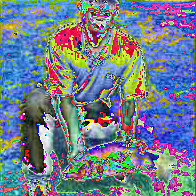

In [ ]:
rgb(image)

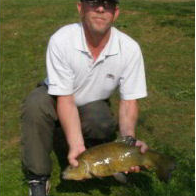

In [ ]:
rgb(image, denorm=in_stats)

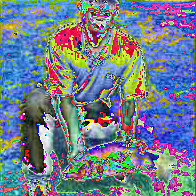

In [ ]:
rgb(image.permute(1, 2, 0), cl=True)

before allocation: torch.cuda.memory_allocated()=0
after allocation: torch.cuda.memory_allocated()=393216


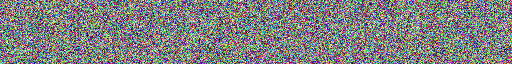

after rgb: torch.cuda.memory_allocated()=393216
after cleanup: torch.cuda.memory_allocated()=0


In [ ]:
if torch.cuda.is_available():
    cudamem = torch.cuda.memory_allocated()
    print(f"before allocation: {torch.cuda.memory_allocated()=}")
    numbers = torch.randn((3, 64, 512), device="cuda")
    torch.cuda.synchronize()
    print(f"after allocation: {torch.cuda.memory_allocated()=}")
    display(rgb(numbers))
    print(f"after rgb: {torch.cuda.memory_allocated()=}")
   
    del numbers
    # torch.cuda.memory.empty_cache()

    print(f"after cleanup: {torch.cuda.memory_allocated()=}")
    test_eq(cudamem >= torch.cuda.memory_allocated(), True)

In [ ]:
# |hide
import nbdev; nbdev.nbdev_export()